<a href="https://colab.research.google.com/github/Rishi-kalasariya/Blood-Vessel-Extraction/blob/main/Blood_vessel_extraction_in_fundus_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, exposure
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter
from skimage.morphology import remove_small_objects
from google.colab.patches import cv2_imshow
from skimage import io

#Iterative Thresholding Function scratch (for finding the optimal threshold value)

In [ ]:
#Iterative Thresholding Function(Finding the optimal threshould value starting)
def iterative_threshold(img):
    # Separate pixels into background and foreground based on the current threshold
    hist, bin_edges = np.histogram(img.flatten(), bins=256, range=(0, 1))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Initial Threshold
    T = np.sum(hist * bin_centers) / np.sum(hist)

    while True:
        background = bin_centers[bin_centers < T]
        foreground = bin_centers[bin_centers >= T]

        # Prevent division by zero if any class is empty
        if len(background) == 0 or len(foreground) == 0:
            break  # Avoid division by zero

        # Compute mean intensity for the background (below threshold)
        MBT = np.sum(background * hist[:len(background)]) / np.sum(hist[:len(background)])

        # Compute mean intensity for the foreground (above threshold)
        MAT = np.sum(foreground * hist[len(background):]) / np.sum(hist[len(background):])

        # Compute the new threshold as the average of the two mean intensities
        new_T = (MBT + MAT) / 2

        #Check for convergence if there is smaller change then threshould then stop
        if abs(new_T - T) < 1e-3:
            break

        #update the new threshold
        T = new_T

    return T

#Functions to extract the strong vessels from the image discard noise

In [ ]:
#Find function used to find the connected component(like DSU algorithm)
def find(x, parent):
    #Using the path compression to reduce the computation required
    if parent[x] != x:
        parent[x] = find(parent[x], parent)
    return parent[x]


In [ ]:
#Function to find the union operation required into finding the connected components(Like DSU algorithm)
def union(x, y, parent, rank):
    #using union by rank
    rootX = find(x, parent)
    rootY = find(y, parent)
    if rootX != rootY:
        if rank[rootX] > rank[rootY]:
            parent[rootY] = rootX
        elif rank[rootX] < rank[rootY]:
            parent[rootX] = rootY
        else:
            parent[rootY] = rootX
            rank[rootX] += 1

In [ ]:
#Implementation from scratch for function of finding connected components
def connectedComponentsWithStats_manual(binary_image, connectivity=8):
    height, width = binary_image.shape
    labels = np.zeros((height, width), dtype=int)
    parent = {}  # Disjoint-set parent map
    rank = {}    # Rank for union by rank
    label = 1    # Start from label 1 (0 is background)

    # Define neighbor offsets for 8-connectivity (can be modified for 4-connectivity)
    neighbor_offsets = [(-1, -1), (-1, 0), (-1, 1), (0, -1),(1, -1)]  # Bottom-left

    # First pass (labeling)
    for i in range(height):
        for j in range(width):
            if binary_image[i, j] == 0:  # Background
                continue

            neighbors = []
            for dy, dx in neighbor_offsets:
                ni, nj = i + dy, j + dx
                #If there is some other pixel otherthan background then add that pixel into the connected component
                if 0 <= ni < height and 0 <= nj < width and labels[ni, nj] > 0:
                    neighbors.append(labels[ni, nj])

            if not neighbors:
                # No connected neighbor → Assign new label
                labels[i, j] = label
                parent[label] = label # Initialize parent of the new label
                rank[label] = 0 # Rank for union by rank heuristic
                label += 1  # Increment label counter
            else:
                # Assign the smallest label among neighbors
                min_label = min(neighbors)
                labels[i, j] = min_label
                # Merge equivalent labels using union-find
                for n in neighbors:
                    union(min_label, n, parent, rank)

    # Second pass: Resolve equivalent labels to ensure unique component IDs
    unique_labels = set()
    for i in range(height):
        for j in range(width):
            if labels[i, j] > 0:
                labels[i, j] = find(labels[i, j], parent)
                unique_labels.add(labels[i, j])

    # Compute stats
    num_labels = max(unique_labels) + 1  # Ensure array size matches the highest label
    stats = np.zeros((num_labels, 5), dtype=int)
    centroids = np.zeros((num_labels, 2), dtype=float)

    for lbl in unique_labels:
        mask = labels == lbl  # Create a mask for this label
        y, x = np.where(mask) # Get pixel coordinates of this component
        if len(x) > 0 and len(y) > 0:
            stats[lbl] = [x.min(), y.min(), x.max() - x.min() + 1, y.max() - y.min() + 1, len(x)]
            centroids[lbl] = [x.mean(), y.mean()]   #Compute centroid

    return num_labels, labels, stats, centroids

In [ ]:
#Function to remove the weaker vessels from the image using connected components
def remove_small_objects_custom(binary_image, min_size):
    binary_image = binary_image.astype(np.uint8)  # Ensure correct type (0 and 1)

    # Convert boolean image (True/False) to 0 and 255(Enhance the finer details so later can be removed as it will come in strongly connected component)
    binary_image[binary_image > 0] = 255

    # Find connected components
    num_labels, labels, stats, _ = connectedComponentsWithStats_manual(binary_image, connectivity=8)

    # Create Empty black image same as input
    cleaned_image = np.zeros_like(binary_image)

    # Retain only components larger than min_size
    for i in range(1, num_labels):  # Skip background (label 0)
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            #Keep only the strong components
            cleaned_image[labels == i] = 255  # Keep the object

    return cleaned_image > 0  # Convert back to boolean

In [ ]:
#function to extract the strong vessels from the image discard weaker vessels
def bwareaopen(img, min_size):

    # Find connected components(connected vessels)
    #with conectivity of 8 we are considering the pixels in 8 directions(4 diagonals)
    num_labels, labels, stats, _ = connectedComponentsWithStats_manual(img, connectivity=8)

    # Create empty black output image
    output = np.zeros_like(img)

    # Keep only components larger than min_size
    for i in range(1, num_labels):  # Skipping background (label 0)
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            #Keep only object that is being greater than min_size
            output[labels == i] = 255  # Keep the object

    #Return the image with strong connected components
    return output

#Implementation of CLAHE histogram equalization from scratch

In [ ]:
#INTERPOLATION FUNCTION
def interpolate(subBin,LU,RU,LB,RB,subX,subY):
    # Initialize an output array of the same shape as subBin (filled with zeros
    subImage = np.zeros(subBin.shape)

     # Compute the total number of pixels in the sub-image (used for normalization)
    num = subX*subY
    # Iterate over each pixel in the sub-image
    for i in range(subX):
        inverseI = subX-i # Distance from the bottom edge
        for j in range(subY):
            inverseJ = subY-j # Distance from the right edge

            # Convert the current pixel value to an integer (used for lookup)
            val = subBin[i,j].astype(int)

            # Perform bilinear interpolation using the four corner values
            subImage[i,j] = np.floor((inverseI*(inverseJ*LU[val] + j*RU[val])+ i*(inverseJ*LB[val] + j*RB[val]))/float(num))
    return subImage

In [ ]:
#ALL UTILITY FUNCTIONS COMBINED INTO ONE FUNCTION
def apply_clahe(img,clipLimit,nrBins=128,nrX=0,nrY=0):
    '''img - Input image
       clipLimit - Normalized clipLimit. Higher value gives more contrast
       nrBins - Number of graylevel bins for histogram("dynamic range")
       nrX - Number of contextial regions in X direction
       nrY - Number of Contextial regions in Y direction'''
    h,w = img.shape
    if clipLimit==1:
        return
    nrBins = max(nrBins,128)
    if nrX==0:
        #Taking dimensions of each contextial region to be a square of 32X32
        xsz = 32
        ysz = 32
        nrX = np.ceil(h/xsz).astype(int)#240
        #Excess number of pixels to get an integer value of nrX and nrY
        excX= int(xsz*(nrX-h/xsz))
        nrY = np.ceil(w/ysz).astype(int)#320
        excY= int(ysz*(nrY-w/ysz))
        #Pad that number of pixels to the image
        if excX!=0:
            img = np.append(img,np.zeros((excX,img.shape[1])).astype(int),axis=0)
        if excY!=0:
            img = np.append(img,np.zeros((img.shape[0],excY)).astype(int),axis=1)
    else:
        xsz = round(h/nrX)
        ysz = round(w/nrY)

    nrPixels = xsz*ysz
    xsz2 = round(xsz/2)
    ysz2 = round(ysz/2)
    claheimg = np.zeros(img.shape)

    if clipLimit > 0:
        clipLimit = max(1,clipLimit*xsz*ysz/nrBins)
    else:
        clipLimit = 50

    minVal = 0 #np.min(img)
    maxVal = 255 #np.max(img)

    #maxVal1 = maxVal + np.maximum(np.array([0]),minVal) - minVal
    #minVal1 = np.maximum(np.array([0]),minVal)

    binSz = np.floor(1+(maxVal-minVal)/float(nrBins))
    LUT = np.floor((np.arange(minVal,maxVal+1)-minVal)/float(binSz))

    #BACK TO CLAHE

    img_int = np.clip(img, 0, 255).astype(np.uint8)

    bins = LUT[img]
    #makeHistogram
    hist = np.zeros((nrX,nrY,nrBins))
    # print(nrX,nrY,hist.shape)
    for i in range(nrX):
        for j in range(nrY):
            bin_ = bins[i*xsz:(i+1)*xsz,j*ysz:(j+1)*ysz].astype(int)
            for i1 in range(xsz):
                for j1 in range(ysz):
                    hist[i,j,bin_[i1,j1]]+=1

    #clipHistogram
    # print("...Clipping the Histogram...")
    if clipLimit>0:
        for i in range(nrX):
            for j in range(nrY):
                nrExcess = 0
                for nr in range(nrBins):
                    excess = hist[i,j,nr] - clipLimit
                    if excess>0:
                        nrExcess += excess

                binIncr = nrExcess/nrBins
                upper = clipLimit - binIncr
                for nr in range(nrBins):
                    if hist[i,j,nr] > clipLimit:
                        hist[i,j,nr] = clipLimit
                    else:
                        if hist[i,j,nr]>upper:
                            nrExcess += upper - hist[i,j,nr]
                            hist[i,j,nr] = clipLimit
                        else:
                            nrExcess -= binIncr
                            hist[i,j,nr] += binIncr

                if nrExcess > 0:
                    stepSz = max(1,np.floor(1+nrExcess/nrBins))
                    for nr in range(nrBins):
                        nrExcess -= stepSz
                        hist[i,j,nr] += stepSz
                        if nrExcess < 1:
                            break

    #mapHistogram
    # print("...Mapping the Histogram...")
    map_ = np.zeros((nrX,nrY,nrBins))
    #print(map_.shape)
    scale = (maxVal - minVal)/float(nrPixels)
    for i in range(nrX):
        for j in range(nrY):
            sum_ = 0
            for nr in range(nrBins):
                sum_ += hist[i,j,nr]
                map_[i,j,nr] = np.floor(min(minVal+sum_*scale,maxVal))

    #BACK TO CLAHE
    #INTERPOLATION
    # print("...interpolation...")
    xI = 0
    for i in range(nrX+1):
        if i==0:
            subX = int(xsz/2)
            xU = 0
            xB = 0
        elif i==nrX:
            subX = int(xsz/2)
            xU = nrX-1
            xB = nrX-1
        else:
            subX = xsz
            xU = i-1
            xB = i

        yI = 0
        for j in range(nrY+1):
            if j==0:
                subY = int(ysz/2)
                yL = 0
                yR = 0
            elif j==nrY:
                subY = int(ysz/2)
                yL = nrY-1
                yR = nrY-1
            else:
                subY = ysz
                yL = j-1
                yR = j
            UL = map_[xU,yL,:]
            UR = map_[xU,yR,:]
            BL = map_[xB,yL,:]
            BR = map_[xB,yR,:]
            #print("CLAHE vals...")
            subBin = bins[xI:xI+subX,yI:yI+subY]
            #print("clahe subBin shape: ",subBin.shape)
            subImage = interpolate(subBin,UL,UR,BL,BR,subX,subY)
            claheimg[xI:xI+subX,yI:yI+subY] = subImage
            yI += subY
        xI += subX

    # cv2_imshow(claheimg)
    if excX==0 and excY!=0:
        return claheimg[:,:-excY]
    elif excX!=0 and excY==0:
        return claheimg[:-excX,:]
    elif excX!=0 and excY!=0:
        return claheimg[:-excX,:-excY]
    else:
        return claheimg



#Implementation of openCV cv2.GaussianBlur() function from scratch

In [ ]:
#function to create the gaussian kernal
def gaussian_kernel(size, sigma):
    # Ensure size is odd
    if size % 2 == 0:
        size = size + 1

    # Create coordinate arrays
    ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    xx, yy = np.meshgrid(ax, ax)

    # Calculate kernel values
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma))

    # Normalize kernel
    return kernel / np.sum(kernel)

In [ ]:
#Function to apply the gaussian kernel on the image
def gaussian_filter_scratch(image, sigma):

    # Calculate kernel size based on sigma
    # Rule of thumb: kernel size = 2 * ceil(2 * sigma) + 1
    size = 2 * int(np.ceil(2 * sigma)) + 1

    # Get kernel from earlier function
    kernel = gaussian_kernel(size, sigma)

    # Apply padding to get the same size
    pad_size = size // 2
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size)), mode='reflect')

    # Initialize output array
    output = np.zeros_like(image, dtype=np.float64)

    # Apply convolution
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            output[i, j] = np.sum(
                padded_image[i:i+size, j:j+size] * kernel
            )

    return output

In [ ]:
#Wrapper function for guassian filter
def manual_gaussian(original_image, sigma=2):
    # Apply The gausian filter (wrapper function)
    custom_result = gaussian_filter_scratch(original_image, sigma=sigma)
    return custom_result

#Main function that takes image path as input, extracts and displays the blood vessels


In [ ]:
#Main function to extract the boolvessels from image
def extractBloodVessels(image_path):
  image = cv2.imread(image_path)  # Reading the image with 3 channel
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

  enhanced_pca=image[:,:,1]  #extracting the green chanel

  #inhance the pixel intensity
  gray_image = (enhanced_pca - np.min(enhanced_pca)) / (np.max(enhanced_pca) - np.min(enhanced_pca))

  #Apply the histogram equilization
  clahe = apply_clahe(np.uint8(gray_image*255),clipLimit=0.03*255,nrBins=128,nrX=0,nrY=0)/255

  # Smoothen the image use gaussian kernal
  smoothed= manual_gaussian(clahe, sigma=5)

  # Extract the vessel structure with difference operation of smoothed image(with less detail) and clahe image(withmore detail)
  vessel_enhanced = smoothed - clahe

  #Extract the very fine vessel structure using the threshoulding
  threshold = iterative_threshold(vessel_enhanced)
  binary_image = vessel_enhanced < (threshold-0.019)  # Convert to binary (inverted vessels)

  #Removing small patches of the noise
  cleaned_image = remove_small_objects_custom(binary_image, min_size=100)

  #In the final image make the vessel white and background as black
  vessel_mask = np.invert(cleaned_image)
  vessel_mask = (vessel_mask * 255).astype(np.uint8)

  #Remove weaker vessels
  vessel_mask = bwareaopen(vessel_mask, 20)

  #creating mask to remove the outer circle from the image
  height, width = vessel_mask.shape[:2]
  mask = np.zeros((height, width), dtype=np.uint8)
  center = (width // 2, height // 2)
  radius = 225
  cv2.circle(mask, center, radius, 255, thickness=-1)

  #Apply the mask on the final image
  masked_image = np.zeros_like(vessel_mask)
  for i in range(vessel_mask.shape[0]):
    for j in range(vessel_mask.shape[1]):
      masked_image[i, j] = vessel_mask[i, j] if mask[i, j] == 255 else 0

  #Just tobe sure do once again threshoulding (optional)
  masked_image[masked_image<100]=0
  masked_image[masked_image>100]=255

  #Plot the output image with the original image for each image
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))

  #Add origianl image
  axes[0].imshow(image, cmap='gray')
  axes[0].set_title('Original Image')

  #Add final Binary image with blood vessels
  axes[1].imshow(masked_image, cmap='gray')
  axes[1].set_title('Final Vessel Segmentation')

  #Write the mask into mask folder
  cv2.imwrite('mask/'+image_path, masked_image)
  plt.show()

#Loop to call over the main function

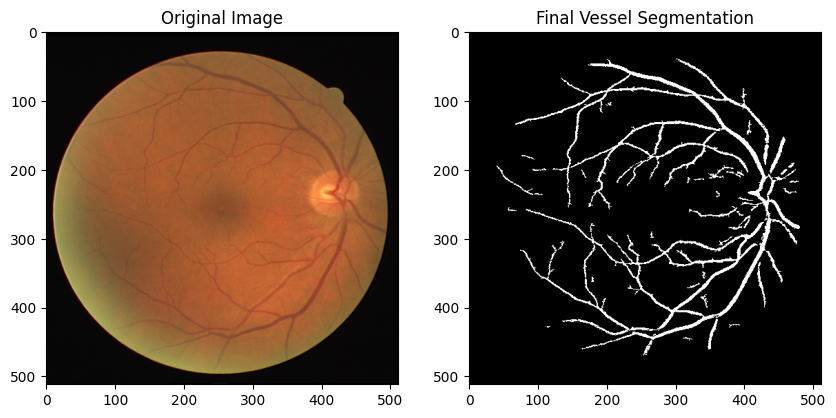

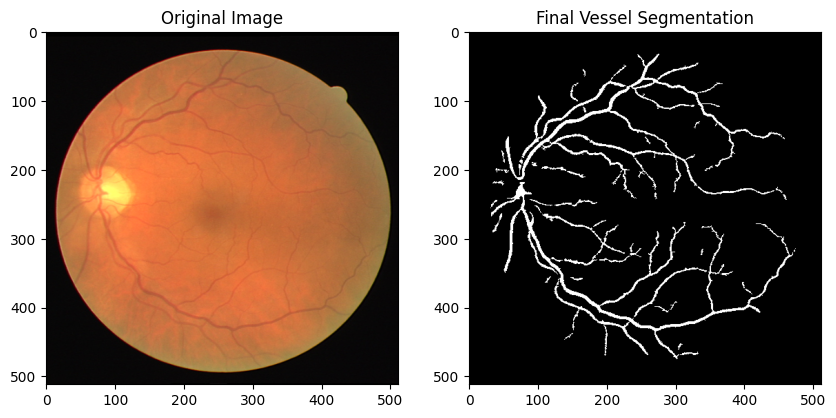

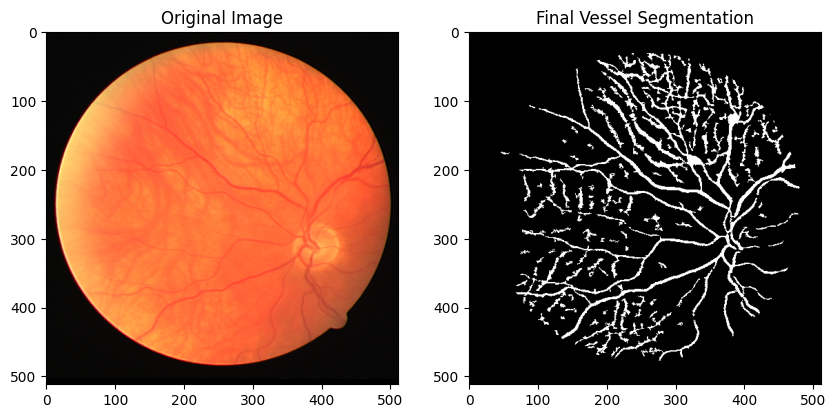

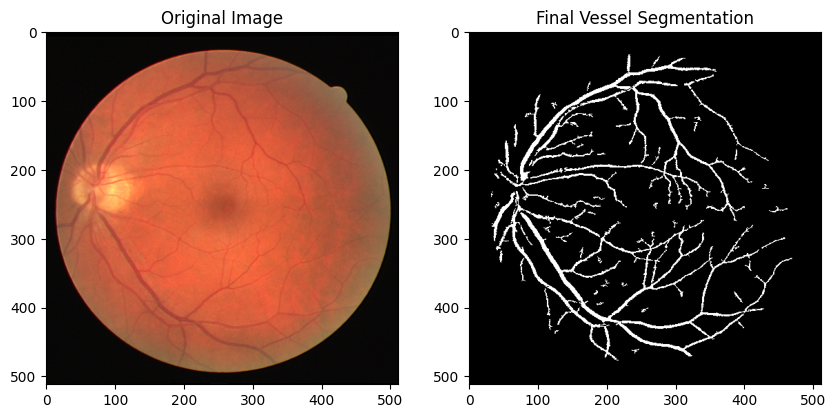

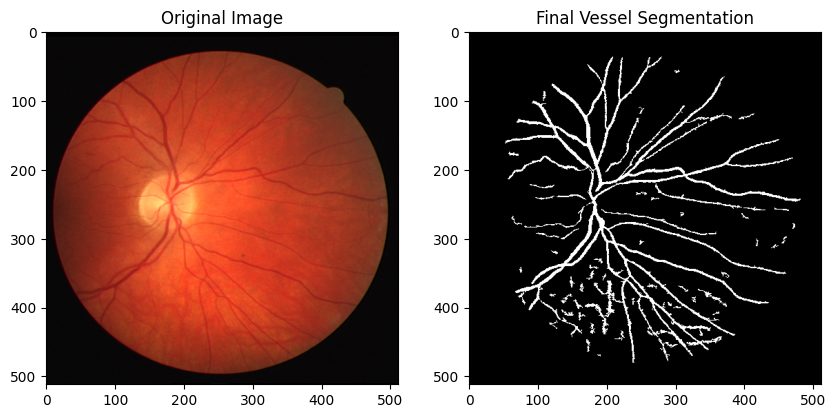

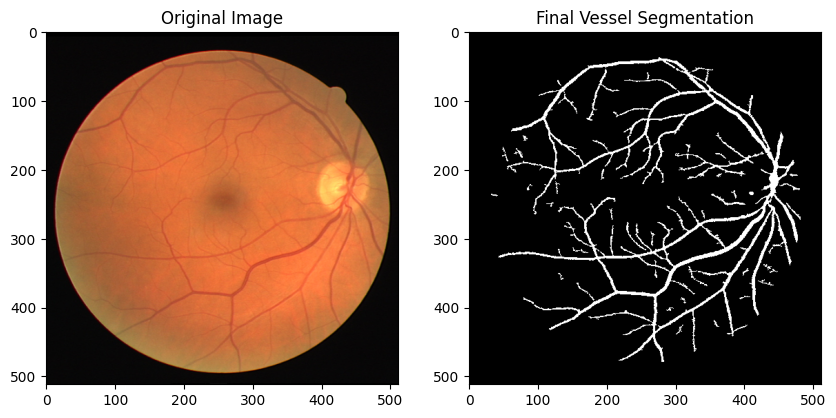

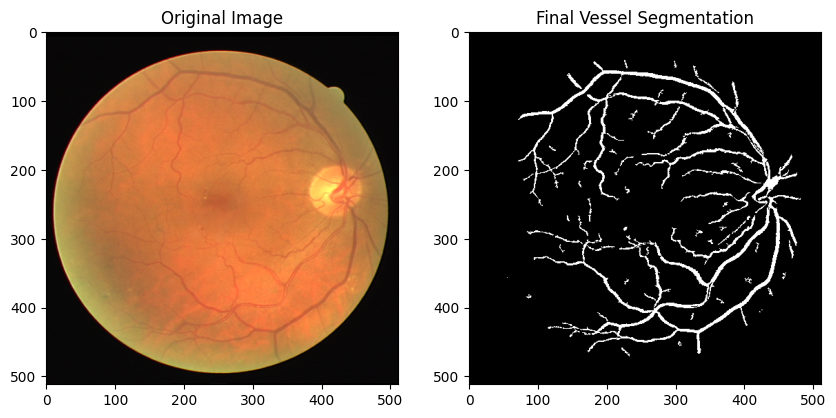

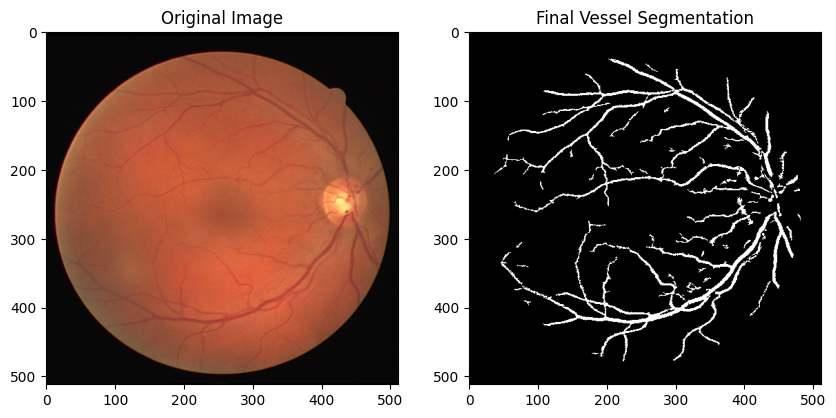

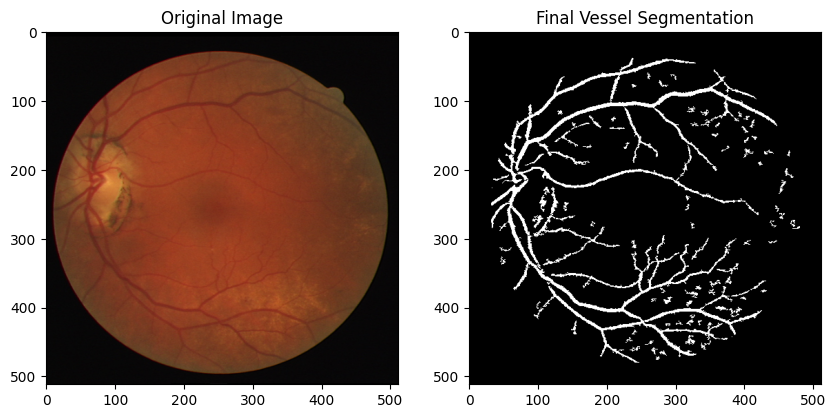

In [ ]:
#For each image call the function
for i in range(9):
  extractBloodVessels(str(i)+'.png')

#Code to generate submissions.csv file

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

all_masks = []

# Read all predicted masks
for i in range(9):
        mask = cv2.imread('mask/' + str(i) + '.png')
        all_masks.append(mask)

# Encoding
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), non 0 - mask, 0 - background
    Returns run length as list
    '''
    run_lengths = []
    for i in range(x.shape[0]*x.shape[1]):
        run_lengths.append([])
    current = 0
    count = 0
    start = 0
    flat = x.T.flatten()
    for i in range(len(flat)):
        dot = flat[i]
        if dot == 0:
            if current == 0:
                continue
            else:
                run_lengths[current-1].extend([start, count])
                current = 0
                count = 0
                start = 0
        else:
            if dot == current:
                count += 1
            elif count != 0:
                run_lengths[current-1].extend([start, count])
                current = 0
                count = 0
                start = 0
            else:
                start = i
                current = dot
                count += 1
    return run_lengths


# Write submission
import csv

# File name
filename = "submission.csv"

# Writing to CSV file
with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["id", "encoding"])  # Header
        for file_id in range(9):
            enc = rle_encoding(all_masks[file_id])
            writer.writerow([file_id, enc])  # Data row

print(f"{filename} has been created successfully.")

submission.csv has been created successfully.
